### Propagation de l'erreur de mesure de pression

Dans ce notebook nous nous penchons sur l'impact de l'erreur de la mesure de la pression à un instant t sur l'évolution de la température avec la profondeur.

In [28]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
class Stallman:

    def __init__(self,dH,K,cw,rhow,lambm,crhom,P,thamp,thmu,Z,T,err_H):
        
        
        self.rhow = rhow
        self.cw = cw          
        self.crhom = crhom
        self.lambm = lambm
        self.dH = dH
        self.K = K
        
        self.thamp= thamp
        self.thmu = thmu
        self.P = P
        self.Z=Z
        self.T=T
        self.err_H =err_H

    
        
    def apply(self):
        #on applique le calcul de la température dans chaque point de temps et de profondeur
        Xz, Xt, Y = np.empty(len(self.Z)*len(self.T)), np.empty(len(self.Z)*len(self.T)), np.empty(len(self.Z)*len(self.T)) #on crée les contenant des valeurs de profondeurs, de temps et de températures
         #création des variables intermédiaires dans le calcul des températures
        self.kape = self.lambm/self.crhom
        self.alphe=self.K*(self.rhow*self.cw)/self.crhom
        self.vt = - self.alphe*(self.dH)
        self.a = ((((self.vt**4+((8*np.pi*self.kape)/self.P)**2)**0.5+self.vt**2)/2)**0.5-self.vt)/(2*self.kape)
        self.b = (((self.vt**4+((8*np.pi*self.kape)/self.P)**2)**0.5-self.vt**2)/2)**0.5/(2*self.kape)
        for i,z in enumerate(self.Z):
            for j,t in enumerate(self.T):
                Xz[i*len(self.T)+j] = z
                Xt[i*len(self.T)+j] = t
                Y[i*len(self.T)+j] = self.thmu + self.thamp*np.exp(-self.a*z)*np.cos(t*2*np.pi/self.P - self.b*z) #on calcul la température en chaque point d'espace et de temps
        self.Xz = Xz
        self.Xt = Xt
        self.Y = Y
    def apply_propag(self):   
        Xz, Xt, Y = np.empty(len(self.Z)*len(self.T)), np.empty(len(self.Z)*len(self.T)), np.empty(len(self.Z)*len(self.T))
        DH=[]
        for j,t in enumerate(self.T):
            #on applique une erreur à notre mesure de pression à un instant t
            dH= self.dH + np.random.normal(0,abs(self.err_H)/2)
            #on propage cette erreur dans les variables du calcul de température
            self.kape = self.lambm/self.crhom
            self.alphe=self.K*(self.rhow*self.cw)/self.crhom
            self.vt = - self.alphe*(dH)
            self.a = ((((self.vt**4+((8*np.pi*self.kape)/self.P)**2)**0.5+self.vt**2)/2)**0.5-self.vt)/(2*self.kape)
            self.b = (((self.vt**4+((8*np.pi*self.kape)/self.P)**2)**0.5-self.vt**2)/2)**0.5/(2*self.kape)
            #on stock les variations de pression
            DH.append(dH)
            for i,z in enumerate(self.Z):
            
                Xz[i*len(self.T)+j] = z
                Xt[i*len(self.T)+j] = t

                #on calcul la température après propagation des erreurs
                Y[i*len(self.T)+j] = self.thmu + self.thamp*np.exp(-self.a*z)*np.cos(t*2*np.pi/self.P - self.b*z)
        self.PropXz = Xz
        self.PropXt = Xt
        self.PropY = Y
        self.PropDH = DH
    
    def plot_diff_pronf(self):
        #on plot la différence entre la température référence et la perturbée en fonction de la profondeur
        #avec un gradient de couleur pour indiquer le temps
        fig = plt.figure(figsize=(9,2.5))
        fig.tight_layout()
        ax = fig.add_subplot()
        colors = matplotlib.cm.get_cmap("magma")
        img = ax.scatter(self.Xz,self.Y-self.PropY,s=0.1,c=self.Xt/(24*3600),cmap=colors)
        ax.set_xlabel("profondeur(m)")
        ax.set_ylabel("différence de température (K)")
        fig.colorbar(img,label="temps (jours)")
        
        plt.show()  
    def plot_diff_time(self):
        #on plot la différence entre la température référence et la perturbée en fonction du temps
        #avec un gradient de couleur pour indiquer la profondeur
        fig = plt.figure(figsize=(9,2.5))
        fig.tight_layout()
        ax = fig.add_subplot()
        colors = matplotlib.cm.get_cmap("magma")
        img = ax.scatter(self.Xt/(24*3600),self.Y-self.PropY,s=0.1,c=self.Xz,cmap=colors)
        ax.set_xlabel("temps (jours)")
        ax.set_ylabel("différence de température (K)")
        fig.colorbar(img,label="profondeur(m)")
        
        plt.show()  


#on définit tous les paramètres du problèmes
N,h = 500, 1
dH = -2*10**(-2)
cw, rhow = 4180, 1000
lambm, lambw = 1, 0.6
crhom = 4*10**6
P = 24*365*3600
thmu, thamp = 273.15+12.5, 12
err_H = 0.045*dH

Z = np.linspace(0,h,N)
T = np.linspace(0,P,int(P/(24*3600)))
K1=10**(-7)
K2=10**(-6)
K3=10**(-5)
K4=10**(-4)

Grace à la documentation sur le capteur, l'erreur relative maximale que peut faire le capteur est de 4.5%. Dans les cas étudiés la différence de charge mesurée est constante de l'ordre de 2cm, ce paramètre est donc choisi comme référence. Le modèle de variation de température est le cas sinusoïdal de période annuelle dont la température varie entre 0.5°C et 24.5°C. Sur une profondeur de 50cm, une courbe est générée par jour. Pour incorporer l'erreur on va à chaque génération journalière calculer des températures non perturbées qui seront la référence d'une part et d'autre part on ajoute une erreur à la charge qui suit une loi normale tel que son intervalle de confiance à 90% soit de plus ou moins 4.5% de la valeur de référence. On trace enfin la diférence entre la température de référence et celle perturbée en fonction de la profondeur pour chaque temps ainsi que cette différence au cours du temps pour chaque profondeurs. Cela est effectuer pour moinslogK = {4,5,6,7}.

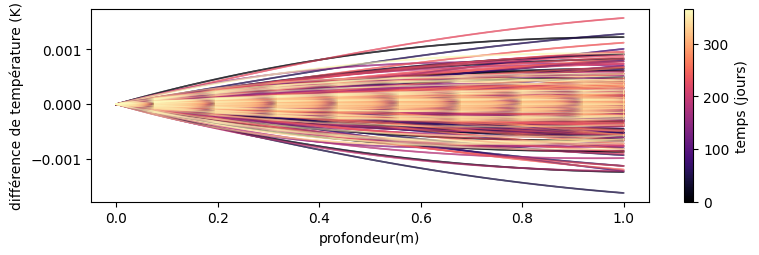

In [29]:
Ref1 = Stallman(dH,K1,cw,rhow,lambm,crhom,P,thamp,thmu,Z,T,err_H)
Ref1.apply()
Ref1.apply_propag()
Ref1.plot_diff_pronf()

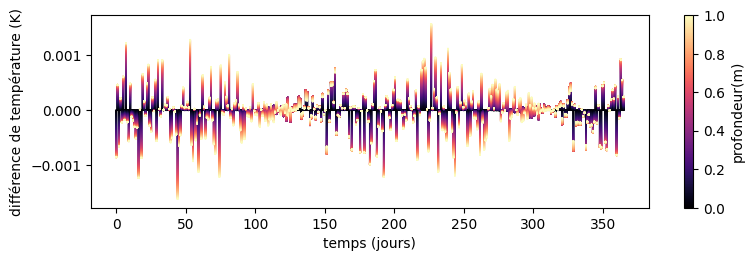

In [30]:
Ref1.plot_diff_time()

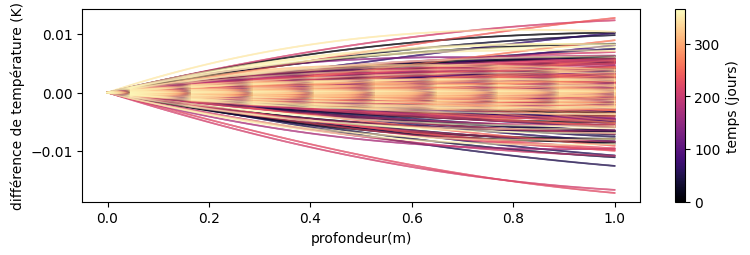

In [31]:
Ref2 = Stallman(dH,K2,cw,rhow,lambm,crhom,P,thamp,thmu,Z,T,err_H)
Ref2.apply()
Ref2.apply_propag()
Ref2.plot_diff_pronf()

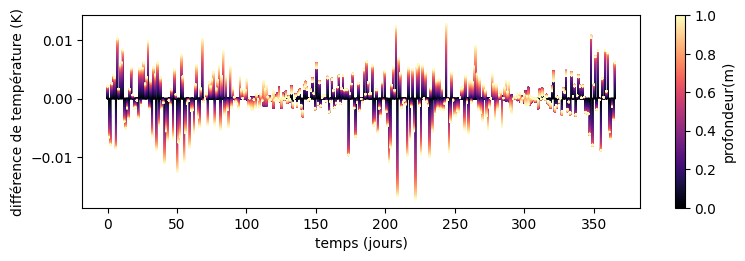

In [32]:
Ref2.plot_diff_time()

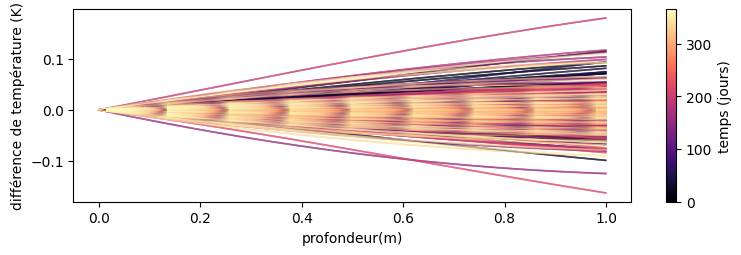

In [33]:
Ref3 = Stallman(dH,K3,cw,rhow,lambm,crhom,P,thamp,thmu,Z,T,err_H)
Ref3.apply()
Ref3.apply_propag()
Ref3.plot_diff_pronf()


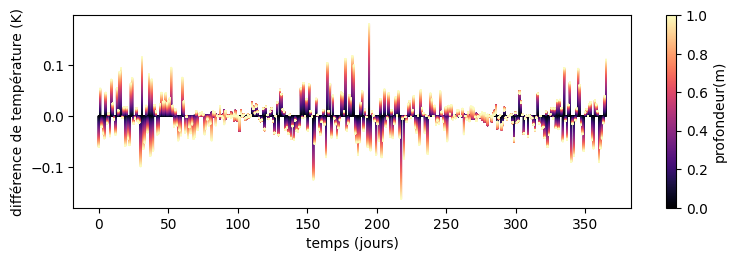

In [34]:
Ref3.plot_diff_time()

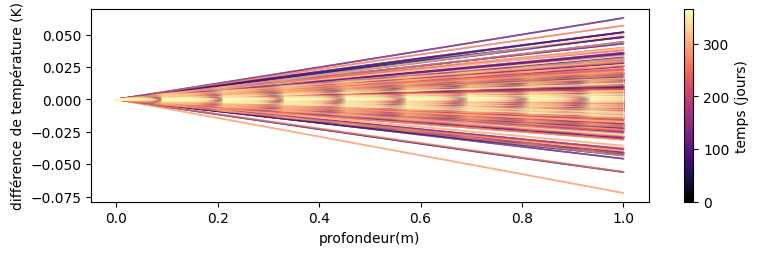

In [35]:
Ref4 = Stallman(dH,K4,cw,rhow,lambm,crhom,P,thamp,thmu,Z,T,err_H)
Ref4.apply()
Ref4.apply_propag()
Ref4.plot_diff_pronf()

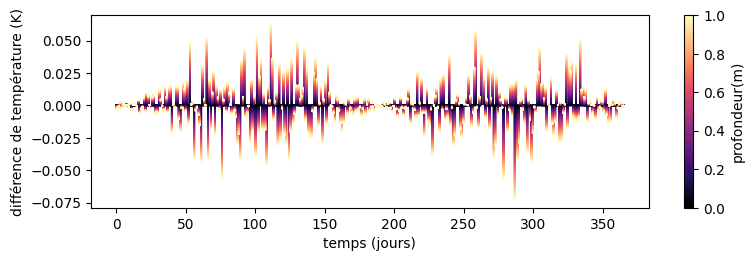

In [36]:
Ref4.plot_diff_time()

Dans le pire des cas où moinslogK = 5 l'erreur de température reste de l'ordre de 0.05 Kelvin ce qui est tout à fait acceptable. De plus on voit que la propagation de l'erreur se fait principalement avec la profondeur plutôt qu'avec le temps. On voit qu'elle augmente avec K jusqu'à un certain point, en traçant des courbes plus profondes on observe que l'erreur passe par un maximum puis décroit, il semble que l'augmentation de l'erreur est compensé par les phénomènes d'atténuation avec la profondeur et pour moinslogK = 4 elle ne croit pas assez vite pour que ce soit le pire des cas sur 50 cm de profondeur.